In [1]:
"""
Script to train the Monolithic baseline for Language-Assisted Deformations.
By Panos Achlioptas (https://optas.github.io)
"""

import torch
import numpy as np
import os.path as osp
import pandas as pd
from torch import optim
from functools import partial
from ast import literal_eval

from changeit3d.in_out.basics import (create_logger,                                      
                                      torch_save_model,
                                      save_state_dicts,
                                      load_state_dicts,
                                      pickle_data)

from changeit3d.in_out.language_contrastive_dataset import LanguageContrastiveDataset
from changeit3d.in_out.arguments import parse_train_test_monolithic_changeit3d
from changeit3d.in_out.pointcloud import pc_loader_from_npz, uniform_subsample, center_in_unit_sphere
from changeit3d.language.vocabulary import Vocabulary
from changeit3d.models.model_descriptions import monolithic_alternative_to_changeit3d
from changeit3d.evaluation.all_metrics import run_all_metrics

Jitting Chamfer 3D
Loaded JIT 3D CUDA chamfer distance


In [2]:
notebook_arguments = []

shape_talk_file = '../data/shapetalk/language/misc/shapetalk_preprocessed_public_merged_utters_version_0.csv'
vocab_file = '../data/shapetalk/language/vocabulary.pkl'
top_pc_dir = '../data/shapetalk/pointclouds/scaled_to_align_rendering'
pretrained_oracle_listener = '../data/pretrained/listeners/oracle_listener/all_shapetalk_classes/rs_2023/listener_dgcnn_based/ablation1/best_model.pkl'

notebook_arguments.extend(['-shape_talk_file', shape_talk_file])
notebook_arguments.extend(['-vocab_file', vocab_file])
notebook_arguments.extend(['-top_pc_dir', top_pc_dir])

notebook_arguments.extend(['--pretrained_model', '../data/pretrained/changers/monolithic_ablation/with_pointclouds/chair_table_lamp_only/best_model.pt'])
notebook_arguments.extend(['--pretrained_oracle_listener', pretrained_oracle_listener])

pretrained_shape_classifier =  '../data/pretrained/pc_classifiers/rs_2022/all_shapetalk_classes/best_model.pkl'
shape_part_classifiers_top_dir = '../data/pretrained/part_predictors/shapenet_core_based'
notebook_arguments.extend(['--pretrained_shape_classifier', pretrained_shape_classifier])
notebook_arguments.extend(['--shape_part_classifiers_top_dir', shape_part_classifiers_top_dir])

notebook_arguments.extend(['--test', 'True'])
notebook_arguments.extend(['--train', 'False'])    

In [3]:
# Argument-handling.
args = parse_train_test_monolithic_changeit3d(notebook_arguments)
logger = create_logger(args.log_dir)
args.restrict_shape_class = ["chair", "table", "lamp"]



Input arguments:


{'batch_size': 128,
 'compute_fpd': True,
 'experiment_tag': None,
 'gpu_id': 0,
 'init_lr': 0.0005,
 'log_dir': './logs',
 'lr_patience': 6,
 'max_train_epochs': 200,
 'n_pc_points': 2048,
 'n_sample_points': 2048,
 'num_workers': 10,
 'pretrained_model': '../data/pretrained/changers/monolithic_ablation/with_pointclouds/chair_table_lamp_only/best_model.pt',
 'pretrained_oracle_listener': '../data/pretrained/listeners/oracle_listener/all_shapetalk_classes/rs_2023/listener_dgcnn_based/ablation1/best_model.pkl',
 'pretrained_shape_classifier': '../data/pretrained/pc_classifiers/rs_2022/all_shapetalk_classes/best_model.pkl',
 'random_seed': 2022,
 'restrict_shape_class': [],
 'scale_in_u_sphere': False,
 'shape_part_classifiers_top_dir': '../data/pretrained/part_predictors/shapenet_core_based',
 'shape_talk_file': '../data/shapetalk/language/shapetalk/secondary_importance/shapetalk_preprocessed_public_merged_utters_version_0.csv',
 'test': True,
 'top_pc_dir': '../dat

In [51]:
##
# Prepare the input data
##
df = pd.read_csv(args.shape_talk_file)
df.tokens_encoded = df.tokens_encoded.apply(literal_eval)
vocab = Vocabulary.load(args.vocab_file)


# constrain training in language of particular classes
if len(args.restrict_shape_class) > 0:
    mask = df.target_object_class.isin(set(args.restrict_shape_class))
    df = df[mask].copy()
    df.reset_index(inplace=True, drop=True)
    logger.info('Restricting to class(es) {}. Total utterances: {}'.format(args.restrict_shape_class, len(df)))


## ensure all relevant shapes are reachable
all_model_uids = set(df.source_uid.unique()).union(set(df.target_uid.unique()))
print('Annotated shapes:', len(all_model_uids))
assert all([osp.exists(osp.join(args.top_pc_dir, x + '.npz')) for x in all_model_uids]), "all pc-files need to exist"


##
# Prepare the data loaders
##

# make df compatible with LanguageContrastive Dataset
df = df.assign(target=df.target_uid)
df = df.assign(distractor_1=df.source_uid)

def to_stimulus_func(x, top_pc_dir, n_samples=2048, random_seed=None, scale_pc=False):
    pc = pc_loader_from_npz(osp.join(top_pc_dir, x + '.npz'))
    pc, _ = uniform_subsample(pc, n_samples, random_seed)
    if scale_pc:
        pc = center_in_unit_sphere(pc)
    return pc


dataloaders = dict()
for split in ['train', 'val', 'test']:
    ndf = df[df.changeit_split == split].copy()
    ndf.reset_index(inplace=True, drop=True)
    seed = None if split == 'train' else args.random_seed
    batch_size = args.batch_size if split == 'train' else 2 * args.batch_size
        
    loader = partial(to_stimulus_func, 
                     top_pc_dir=args.top_pc_dir, n_samples=args.n_pc_points, 
                     random_seed=seed, scale_pc=args.scale_in_u_sphere)
        
    dataset = LanguageContrastiveDataset(ndf,
                                         loader,
                                         n_distractors=1,
                                         shuffle_items=False) # important, target *always* last
    
    dataloaders[split] = torch.utils.data.DataLoader(dataset=dataset,
                                                     batch_size=args.batch_size,
                                                     shuffle=split == 'train',
                                                     num_workers=args.num_workers,
                                                     worker_init_fn=lambda x: np.random.seed(seed))


device = torch.device("cuda:" + str(args.gpu_id))
model = monolithic_alternative_to_changeit3d(args.n_pc_points, vocab)
model = model.to(device)


##
# Optimization 
##
optimizer = optim.Adam(model.parameters(), lr=args.init_lr, weight_decay=args.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",
                                                          factor=0.5, patience=args.lr_patience,
                                                          verbose=True, min_lr=5e-7)


## Optionally, load pretrained model.
if args.pretrained_model is not None:
    best_epoch = load_state_dicts(args.pretrained_model, model=model, 
                                  optimizer=optimizer, lr_scheduler=lr_scheduler, map_location="cpu")
    logger.info(f'Loading pretrained model @epoch {best_epoch}')
    model = model.to(device)    
    start_epoch = best_epoch
else:
    start_epoch = 0

Restricting to class(es) ['chair', 'table', 'lamp']. Total utterances: 50165
Annotated shapes: 17096
Loading pretrained model @epoch 15


In [52]:
##
# Train it.
##

if args.train:
    epochs_val_not_improved = 0
    best_val_loss = np.Inf    
    checkpoint_file = osp.join(args.log_dir, 'best_model.pt')

    logger.info('Start training of the Monolithic alternative to ChangeIt3DNet.')
    for epoch in range(start_epoch + 1, start_epoch + args.max_train_epochs + 1):
        np.random.seed()

        # training
        train_losses = \
            model.single_epoch_train(dataloaders['train'],                                     
                                     optimizer,
                                     device=device)
            
        logger.info(f"@epoch-{epoch}")
        logger.info("train/val losses:")
        train_losses_str = " ".join(["{:15} {:.5f}".format(key, val) for key, val in train_losses.items()])
        logger.info(train_losses_str)

        # validation
        val_losses = \
            model.evaluate(dataloaders['val'],                                                      
                           device=device)
        val_losses_str = " ".join(["{:15} {:.5f}".format(key, val) for key, val in val_losses.items()])
        logger.info(val_losses_str)

        lr_scheduler.step(val_losses['total_loss'])
        if val_losses['total_loss'] < best_val_loss:
            best_val_loss = val_losses['total_loss']
            epochs_val_not_improved = 0
            save_state_dicts(checkpoint_file, epoch=epoch, model=model,
                             optimizer=optimizer, lr_scheduler=lr_scheduler)
        else:
            epochs_val_not_improved += 1
            logger.info("* validation loss did not improved *")

        if epochs_val_not_improved == args.train_patience:
            logger.warning(
                f'Validation loss did not improve for {epochs_val_not_improved} consecutive epochs. Training is stopped.')
            break

    logger.info('Training is done!')

    # Load best model per validation set
    best_epoch = load_state_dicts(checkpoint_file, model=model)
    logger.info(f'per-validation optimal epoch {best_epoch}')

    # save one more time the model, this time as a module directly working for inference
    checkpoint_pkl_file = osp.join(args.log_dir, 'best_model.pkl')
    torch_save_model(model, checkpoint_pkl_file)

In [53]:
def prepare_dataset_for_testing(check_loader):
    ### Prepare a dataset that is fair w.r.t other ablations systems: i.e., use single utterances as input to change the input; not multi- (merged) ones    
    ### the same here.      
    
    ndf = check_loader.dataset.df.copy()
    
    # Now *break down the **merged** sentences
    # (use the special token that was used to merge them (which in our case that is vocab.dia) )
    disjoint_utters = ndf.utterance_spelled.apply(lambda x: x.split(vocab.idx2word[vocab.dia])) 
    
    def pick_one_at_random(utters):
        np.random.seed(args.random_seed) 
        return np.random.choice(utters)

    single_utter = disjoint_utters.apply(pick_one_at_random)  # pick one of the many at random        
    single_utter = single_utter.apply(lambda x: x.strip())
    tokens = single_utter.apply(lambda x: x.split())
    max_len = tokens.apply(len).max()
    ndf['tokens_encoded'] = tokens.apply(lambda x: vocab.encode(x, max_len=max_len))
    ndf['utterance_spelled'] = single_utter
    ndf['tokens'] = tokens
    ndf = ndf.drop(columns={'utterance', 'tokens_len'})
    
    dataset = LanguageContrastiveDataset(ndf,
                                        loader,
                                        n_distractors=1,
                                        shuffle_items=False) # important, target *always* last

    test_loader = torch.utils.data.DataLoader(dataset=dataset,
                                            batch_size=args.batch_size,
                                            shuffle=False,
                                            num_workers=args.num_workers,
                                            worker_init_fn=lambda x: np.random.seed(args.random_seed))
    return test_loader
    
    
if args.test:
    check_loader = dataloaders['test']
    # check_loader = prepare_dataset_for_testing(dataloaders['test'])
        
    all_reconstructions = []
    all_input_pcs = []
    all_tokens_used = []            
        
    model.eval()
    with torch.no_grad():        
        for batch in check_loader:
            tokens = batch['tokens']
            source = batch['stimulus'][:, 0]
            output = model(tokens.to(device), source.to(device))
            all_reconstructions.append(output.cpu())
            all_input_pcs.append(source.cpu())
            all_tokens_used.append(output.cpu())            
        all_reconstructions = torch.cat(all_reconstructions).numpy()
        all_input_pcs = torch.cat(all_input_pcs).numpy()
        all_tokens_used = torch.cat(all_tokens_used).numpy()
        
    if all_reconstructions.shape[-2] != args.n_sample_points:
        all_reconstructions = np.array([uniform_subsample(s, args.n_sample_points, args.random_seed)[0] for s in all_reconstructions])
    
    if all_input_pcs.shape[-2] != args.n_sample_points:
        all_input_pcs = np.array([uniform_subsample(s, args.n_sample_points, args.random_seed)[0] for s in all_input_pcs])
        
    sentences = check_loader.dataset.df.utterance_spelled.values    
    gt_classes = check_loader.dataset.df.source_object_class

    results_on_metrics = run_all_metrics(all_reconstructions, all_input_pcs, gt_classes, sentences, vocab, args, logger)
    pickle_data(osp.join(args.log_dir, 'evaluation_metric_results.pkl'), results_on_metrics)

Chamfer Distance (all pairs), Average: 1.283
Chamfer Distance (all pairs), Average, per class:
  shape_class  holistic-chamfer
0       chair             0.977
1        lamp             1.635
2       table             1.305
LAB Average:0.4906977713108063
LAB-related-metric: Times edit is favored by listener against the original input, Average:0.9382663847780127
LAB (all pairs), Average, per class:
  shape_class       LAB
0       chair  0.563221
1        lamp  0.463278
2       table  0.450947
A classifier trained to recognize 30 shape classes was loaded.

 (Average) Class Distortion for lamp: 0.681196391582489

 (Average) Class Distortion for table: 0.07332262396812439

 (Average) Class Distortion for chair: 0.05972958728671074

 (Average) Class Distortion (all classes): 0.22529630381180796

The classifier guesses the classes of the ** gt pointclouds ** with accuracy 0.9469344608879493
| shape_class   |   guessed_correct |
|:--------------|------------------:|
| chair         |          

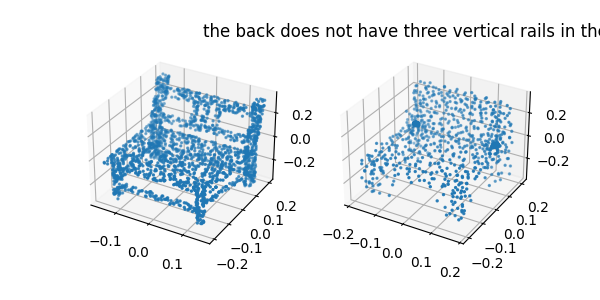

In [50]:
from changeit3d.utils.visualization import visualize_point_clouds_3d_v2
ridx = np.random.randint(len(all_reconstructions))
vis_axis_order=[0, 2, 1]

visualize_point_clouds_3d_v2([all_input_pcs[ridx],
                              all_reconstructions[ridx]], title_lst=["", check_loader.dataset.df.utterance_spelled.iloc[ridx]])